# **LDA Topic modeling using both published and public resources dataset for training and testing**

In [1]:
import csv
import re
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from collections import defaultdict

# We need this dataset in order to use the tokenizer
#nltk.download('punkt')
#import nltk
#nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk import flatten
# Also download the list of stopwords to filter out
#nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet as wn
#nltk.download('wordnet')def get_wordnet_pos(treebank_tag):

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

from nltk import pos_tag

import numpy
numpy.random.seed(1) # setting random seed to get the same training model results each time.

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# these resources are all test resources,which may need to be filtered out from input data
bad_data_id = {
    "c40d9567678740dab868f35440a69b30",
    "c28359056de64680bbdfc64514e1f599",
    "9d5ac26acb8c404fb9ab6e3573ec2c49",
    "316018ccfbdf47928687f81e1b0deb68",
    "fa27117fdf8a462ca320e618dea9a576",
    "9981d0052ae44546912be39ac786a0f9"
}

import pyLDAvis

stop_words = stopwords.words('english')
custom_stop_words = ['include', 'included', 'includes', 'including', 'contain', 'contains', 'containing', 'file', 'et', 'al', 'different', 
                    'dat', 'edu', 'not', 'would', 'say', 'could', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 
                     'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'from', 'published', 
                     'christina', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'used', 'using', 'use', 'public', 
                     'private', 'new', 'west', 'east', 'south', 'north', 'approximately', 'four', 'low', 'high', 'available', 'mile', 'daily', 
                     'year', 'month', 'variable', 'square', 'city', 'foot', 'area', 'within', 'provide', 'firm', 'file', 'state', 'information', 
                     'well', 'university']
stop_words.extend(custom_stop_words)



def process_text(text):
    # Make all the strings lowercase
    text = text.lower()
    # remove urls
    text = re.sub('http[s]?://\S+', '', text)
    # remove non alphabetic characters except dash symbol which is converted to underbar that indicates phrases
    text = re.sub('[-]', '_', text)
    text = re.sub('[^A-Za-z_]', ' ', text.lower())

    # Tokenize the text; this is, separate every sentence into a list of words
    # Since the text is already split into sentences you don't have to call sent_tokenize
    tokenized_text = word_tokenize(text)
    
    tag_map = defaultdict(lambda : wn.NOUN)    
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV    
    
    # Remove the stopwords and lemmatize each word
    clean_text = [
        lemmatizer.lemmatize(word[1:] if word.startswith('_') else word, tag_map[tag[0]]) for word, tag in pos_tag(tokenized_text)
        if word not in stop_words and len(word)>2
    ]
    # this final output is a list of words - remove stop words from lemmatized text to completely remove stop words
    return [word for word in clean_text if word not in stop_words] 

def process_keyword(keyword):
    # remove paratheses
    text = re.sub('\([^()]*\)', '', keyword)
    text = text.strip()    
    # convert dash and space symbols to underbar that indicates phrases
    text = re.sub('[- ]', '_', text)
    return text


In [2]:
# read all published and public hydroshare data
file_name = '/projects/hackathon/ML-Training/hs-ml/data/hs_data.csv'
all_data = [row for row in csv.reader(open(file_name))]
# Remove the first row, since it only has the labels
all_data = all_data[1:]
print('total number of data instances:', len(all_data))

# process keywords
keywords = [row[3].lower().strip().strip(';').split(';') for row in all_data]
for i, kw_list in enumerate(keywords):
    for j, kw in enumerate(kw_list):
        kw_list[j] = process_keyword(kw)
print("total number of keywords: ", len(keywords))


total number of data instances: 4228
total number of keywords:  4228


In [3]:
# concatenate title and abstract to prepare for training texts
all_texts = ['{} {}'.format(row[2], row[4]) for row in all_data]
for i, text in enumerate(all_texts):
    kw_text = ' '.join(keywords[i])
    all_texts[i] = '{} {}'.format(text, kw_text) 

print("Number of full text rows:", len(all_texts))
keywords_set = set(flatten(keywords))
print("number of keywords in keywords_set", len(keywords_set))
#print(keywords_set)


Number of full text rows: 4228
number of keywords in keywords_set 4723


In [4]:
# split total_data into train and test data
from sklearn.model_selection import train_test_split

input_data, test_data, input_keywords, test_keywords = train_test_split(all_texts, keywords, test_size=0.2, train_size=0.8)
print("length of training data: ", len(input_data), ", length of test data: ", len(test_data))

length of training data:  3382 , length of test data:  846


In [5]:
%time docs = [process_text(text) for text in input_data]
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to texts
# higher threshold means few phrases, heavily depends on scoring function, which can be set as 'default' or 'npmi'
bigram = Phrases(docs, min_count=5, threshold=10, scoring='default') 
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token and token not in docs[idx]:
            # Token is a bigram, add to document.
            docs[idx].append(token)
            #print("in bigram processing: ", token)
    for token in trigram[docs[idx]]:
        if '_' in token and token not in docs[idx]:
            # Token is a bigram, add to document.
            docs[idx].append(token)
            #print("in trigram processing: ", token)


CPU times: user 27.3 s, sys: 0 ns, total: 27.3 s
Wall time: 26 s


In [6]:
docs_dictionary = Dictionary(docs)
#docs_dictionary.filter_extremes(no_below=10, no_above=0.2)
corpus = [docs_dictionary.doc2bow(text) for text in docs]
print('number of documents in corpus', len(corpus))
print(docs_dictionary)
#print(docs_dictionary.token2id)

number of documents in corpus 3382
Dictionary(19086 unique tokens: ['across', 'along', 'analysis', 'analysis_system', 'analysis_system_fia_flood']...)


In [7]:

# train an LDA model to instruct Gensim to find specified number of topics
# symmetric alpha is default, can also set it to "auto" and 'asymmetric'
# per_word_topics, if set to true, the model also computes a list of topics, sorted in descending order of most likely topics for each word 
# along with their phi values multiplied by the feature length (i.e., word count)
num_of_topics = 14
%time model = LdaModel(corpus, num_topics=num_of_topics, alpha='auto', id2word=docs_dictionary, passes=15, per_word_topics=True)


#topics = model.show_topics(num_words=10, formatted=False)
#print("topics shape: ", model.get_topics().shape)
#for topic in topics:
#    print(topic)
#top_topics = model.top_topics(corpus=corpus, texts=docs, dictionary=docs_dictionary, topn=10, coherence='c_v')
#print("top topics using c_v coherence measure: ")
#for topic in top_topics:
#    print(topic, '\n')


CPU times: user 1min 2s, sys: 0 ns, total: 1min 2s
Wall time: 35.3 s


In [8]:
from pprint import pprint
pprint(model.print_topics())

[(0,
  '0.016*"water" + 0.016*"test" + 0.014*"data" + 0.012*"basin" + 0.010*"land" '
  '+ 0.010*"model" + 0.009*"river" + 0.008*"pennsylvania" + 0.008*"access" + '
  '0.008*"delaware"'),
 (1,
  '0.021*"data" + 0.020*"temperature" + 0.015*"model" + 0.012*"radiation" + '
  '0.012*"precipitation" + 0.009*"watershed" + 0.009*"gage" + 0.008*"station" '
  '+ 0.007*"soil" + 0.007*"air"'),
 (2,
  '0.035*"soil" + 0.018*"temperature" + 0.014*"water" + 0.009*"sensor" + '
  '0.009*"moisture" + 0.008*"dts" + 0.006*"ctemps" + 0.006*"depth" + '
  '0.005*"data" + 0.005*"study"'),
 (3,
  '0.026*"data" + 0.020*"flow" + 0.019*"discharge" + 0.018*"groundwater" + '
  '0.014*"stream" + 0.013*"site" + 0.010*"river" + 0.010*"temperature" + '
  '0.008*"water" + 0.008*"measurement"'),
 (4,
  '0.018*"resource" + 0.015*"map" + 0.013*"data" + 0.012*"water" + '
  '0.010*"texas" + 0.010*"support" + 0.010*"watershed" + 0.009*"gi" + '
  '0.009*"project" + 0.007*"boundary"'),
 (5,
  '0.022*"dissolve" + 0.021*"data" + 0

In [9]:
pprint(model.top_topics(texts=docs, coherence='c_v', topn=10))

[([(0.037704494, 'pequea'),
   (0.029090602, 'mmw'),
   (0.028218852, 'model_my_watershed'),
   (0.028021676, 'creek'),
   (0.027665855, 'mmw_model_my_watershed'),
   (0.02460848, 'watershed'),
   (0.02214189, 'cbf'),
   (0.02083507, 'export'),
   (0.020372994, 'land'),
   (0.020142052, 'sub_watershed')],
  0.9330667575595776),
 ([(0.1044351, 'historic'),
   (0.07650507, 'precipitation'),
   (0.06700156, 'republic'),
   (0.066786, 'dominican'),
   (0.038218945, 'discharge'),
   (0.033121303, 'indrhi'),
   (0.03236983, 'dominican_republic'),
   (0.022336992, 'historic_precipitation'),
   (0.02027371, 'indrhi_precipitation'),
   (0.02027371, 'dominican_republic_indrhi_precipitation')],
  0.8429720693138331),
 ([(0.031609762, 'data'),
   (0.02823403, 'model'),
   (0.018520046, 'hydroshare'),
   (0.011952487, 'resource'),
   (0.011317005, 'notebook'),
   (0.008754814, 'research'),
   (0.00849586, 'hydrologic'),
   (0.0075475504, 'jupyter'),
   (0.007169682, 'science'),
   (0.006954134, 'su

## **Find dominant topic and its percentage contribution in each document instance**

In [10]:
pd.options.display.max_colwidth = 100

sent_topics_df = pd.DataFrame()

for i, row_list in enumerate(model[corpus]):
    row = row_list[0] if model.per_word_topics else row_list
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:
            wp = model.show_topic(topic_num)
            topic_keywords_list = [word for word, prop in wp]
            topic_keywords = "; ".join(topic_keywords_list)
            # compute cosine similarity between topic keywords and input keywords
            topic_keywords_set = {w for w in topic_keywords_list}
            input_keywords_set = {w for w in input_keywords[i]}
            #rvector = topic_keywords_set.union(input_keywords_set)
            rvector = input_keywords_set
            l1 = []; l2 = []
            for w in rvector:
                if w in topic_keywords_set:
                    l1.append(1)
                else:
                    l1.append(0)
                if w in input_keywords_set:
                    l2.append(1)
                else:
                    l2.append(0)
            dot_product = sum(n1*n2 for n1, n2 in zip(l1, l2))
            mag1 = sum(l1)**0.5
            mag2 = sum(l2)**0.5
            if mag1 == 0 or mag2 == 0:
                cos_sim = 0
            else:    
                cos_sim = dot_product/(mag1*mag2)
            sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords, input_keywords[i], cos_sim]), ignore_index=True)            
        else:
            break
            
contents = pd.Series(docs)
sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
sent_topics_df.reset_index()
sent_topics_df.columns = ['Dominant_Topic', 'Percent_Contribution', 'Topic_Keywords', 'Curated', 'Similarity', 'Text']
sent_topics_df
            

,Dominant_Topic,Percent_Contribution,Topic_Keywords,Curated,Similarity,Text
0,6.0,0.8336,river; watershed; usace; cwm; usace_cwm; basin; collection; resource; watershed_collection; system,"[ressim, geohms, usace, iwrss, usace_corps_water_management_system, fia, ras, kansas_river_water...",0.353553,"[usace, cwm, kansas, river, watershed, corp, water, management, system, cwms, interrelated, mode..."
1,6.0,0.5156,river; watershed; usace; cwm; usace_cwm; basin; collection; resource; watershed_collection; system,[watershed],1.000000,"[watershed, test, watershed, test, watershed]"
2,1.0,0.9108,data; temperature; model; radiation; precipitation; watershed; gage; station; soil; air,[dem],0.000000,"[logan, dem, test, hydrods, service, dem]"
3,6.0,0.9731,river; watershed; usace; cwm; usace_cwm; basin; collection; resource; watershed_collection; system,[corps_water_management_system],0.000000,"[usace, cwm, cape, fear, watershed, centerline, usace, cwm, cape, fear, watershed, collection, r..."
4,1.0,0.9937,data; temperature; model; radiation; precipitation; watershed; gage; station; soil; air,"[temperature, fire, rain, humidity, weather, solar_radiation, soil_moisture, empire_fire, precip...",0.426401,"[illilouette, creek, basin, weather, station, data, part, project, study, effect, wildfire, illi..."
...,...,...,...,...,...,...
3377,8.0,0.3079,water; change; climate; project; data; utah; system; impact; study; puerto,"[germination, wetlands, plant_restoration, regeneration_traits]",0.000000,"[improve, native, specie, recruitment, seed_based, wetland, restoration, one, great, threat, gre..."
3378,7.0,0.9582,data; model; hydroshare; resource; notebook; research; hydrologic; jupyter; science; support,"[demo, jupyterhub]",0.000000,"[hello, jupyterhub, demo, hydroshare, python, notebook, server, demo, jupyterhub, jupyterhub_dem..."
3379,7.0,0.9132,data; model; hydroshare; resource; notebook; research; hydrologic; jupyter; science; support,"[vic, landslide, hydrology, north_cascades, national_park, landlab]",0.000000,"[regional, landslide, hazard, landlab, noca, observatory, noca, landslide, observatory, host, dr..."
3380,1.0,0.6372,data; temperature; model; radiation; precipitation; watershed; gage; station; soil; air,"[reduction_potential, bigelow_site, catalina_jemez, soil_redox_potential]",0.000000,"[cjczo, soil, redox, potential, bigelow, site, reduction, redox, potential, measure, continuousl..."


In [11]:
sent_topics_df.to_csv('training_topic_info_data_frame_accurate_14.csv')

## **Find the most representative text for each topic in training data**

In [12]:
sim_series = sent_topics_df['Similarity']
zero_cnt = sim_series.astype(bool).sum()
print("mean of similarity measures: ", sim_series.mean())
print("number of zeros:", zero_cnt, "number of non-zeros:", sim_series.count()-zero_cnt)
print("mean of non-zero similarity measures: ", sim_series.replace(0, numpy.NaN).mean())

mean of similarity measures:  0.23797814652127686
number of zeros: 1155 number of non-zeros: 2227
mean of non-zero similarity measures:  0.6968329796839465


In [13]:
sent_topics_sorted_df = pd.DataFrame()
sent_topics_grp_df = sent_topics_df.groupby('Dominant_Topic')
for i, grp in sent_topics_grp_df:
    sent_topics_sorted_df = pd.concat([sent_topics_sorted_df, grp.sort_values(['Percent_Contribution'], ascending=False).head(1)], axis=0)

print("Mean of dominant_topic_percent_contribution: ", sent_topics_sorted_df[['Percent_Contribution']].mean(axis=0))

# Reset Index    
sent_topics_sorted_df.reset_index(drop=True, inplace=True)
sent_topics_sorted_df


Mean of dominant_topic_percent_contribution:  Percent_Contribution    0.996064
dtype: float64


,Dominant_Topic,Percent_Contribution,Topic_Keywords,Curated,Similarity,Text
0,0.0,0.9983,water; test; data; basin; land; model; river; pennsylvania; access; delaware,"[catchment, inlandwaters, strahler, stream_order]",0.000000,"[digital, elevation, model, dem, derive, first_, second_order, catchment, huc, breakthrough, wat..."
1,1.0,0.9942,data; temperature; model; radiation; precipitation; watershed; gage; station; soil; air,"[meadow, map, shrub, fire, illilouette, wetland, conifer, vegetation, yosemite]",0.000000,"[vegetation, map, illilouette, creek, basin, illilouette, creek, basin, yosemite, national, park..."
2,2.0,0.9976,soil; temperature; water; sensor; moisture; dts; ctemps; depth; data; study,"[carbon_14, soil_organic_matter__density_fractionation, luquillo, carbon_to_nitrogen_mass_ratio,...",0.000000,"[lczo, soil, biogeochemistry, soil, organic, matter, iron, phase, crystallinity, northeastern, p..."
3,3.0,0.9962,data; flow; discharge; groundwater; stream; site; river; temperature; water; measurement,"[streambed, stream, ground_water, lakebed, zlotnik, solomon, gilmore, genereux, hydrology, speci...",0.267261,"[automated, seepage, meter, soft_bottom, stream, lake, supplemental, describe, automatic, seepag..."
4,4.0,0.9959,resource; map; data; water; texas; support; watershed; gi; project; boundary,"[surface_water, parflow, urban_hydrology, groundwater, hydrologic_modeling]",0.000000,"[redbrook, parflow, clm, model, input, six, headwater, catchment, gwynn, fall, watershed, locate..."
5,5.0,0.9979,dissolve; data; sample; site; water; collect; snow; nitrogen; chemistry; stream,"[boulder, surface_water_chemistry, carbon,_dissolved_organic, cloud_cover, magnesium,_dissolved,...",0.000000,"[bcczo, stream, water, chemistry, surface, water, chemistry, isaac, bukoski, thesis, boulder, cr..."
6,6.0,0.9961,river; watershed; usace; cwm; usace_cwm; basin; collection; resource; watershed_collection; system,"[ressim, geohms, usace, iwrss, usace_corps_water_management_system, white_river_watershed, fia, ...",0.353553,"[usace, cwm, white, river, watershed, corp, water, management, system, cwms, interrelated, model..."
7,7.0,0.9970,data; model; hydroshare; resource; notebook; research; hydrologic; jupyter; science; support,"[jupyter, earthcube, ecahm18]",0.577350,"[hydroshare, jupyterhub, strategy, collaborative, cloud, base, data, share, modeling, analysis, ..."
8,8.0,0.9957,water; change; climate; project; data; utah; system; impact; study; puerto,"[universities, colleges, higher_education, certificate, technical, vocational, 2018_si_workshop,...",0.000000,"[college, example, point, datalayer, show, location, institution, education, massachusetts, site..."
9,9.0,0.9976,pequea; mmw; model_my_watershed; creek; mmw_model_my_watershed; watershed; cbf; export; land; su...,"[firm, flood_insurance_rate_map, inlandwaters, transportation, hydrology, special_flood_hazard_a...",0.000000,"[national, flood, hazard, layer, philadelphia, county, national, flood, hazard, layer, nfhl, dat..."


## **Word Clouds of Top 10 Keywords in Each Topic**

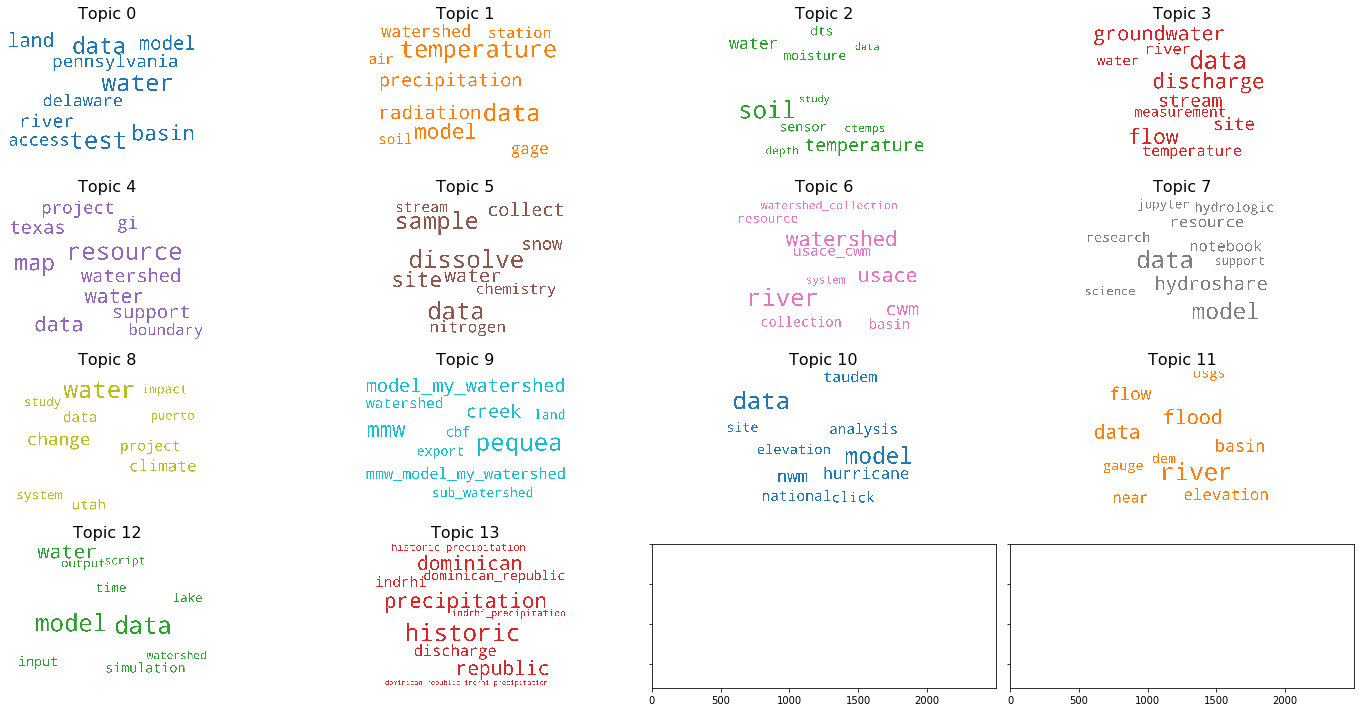

In [12]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors


def topics_per_document(model, corpus, start=0, end=-1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, word_topics, word_phi_values = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)


cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
topics = model.show_topics(num_topics=num_of_topics, formatted=False)

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i-len(cols)] if i >= len(cols) else cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(4, 4, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i >= len(topics):
        break
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
dominant_topics, topic_percentages = topics_per_document(model=model, corpus=corpus)  

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## **Word Counts of Top Topic Keywords**

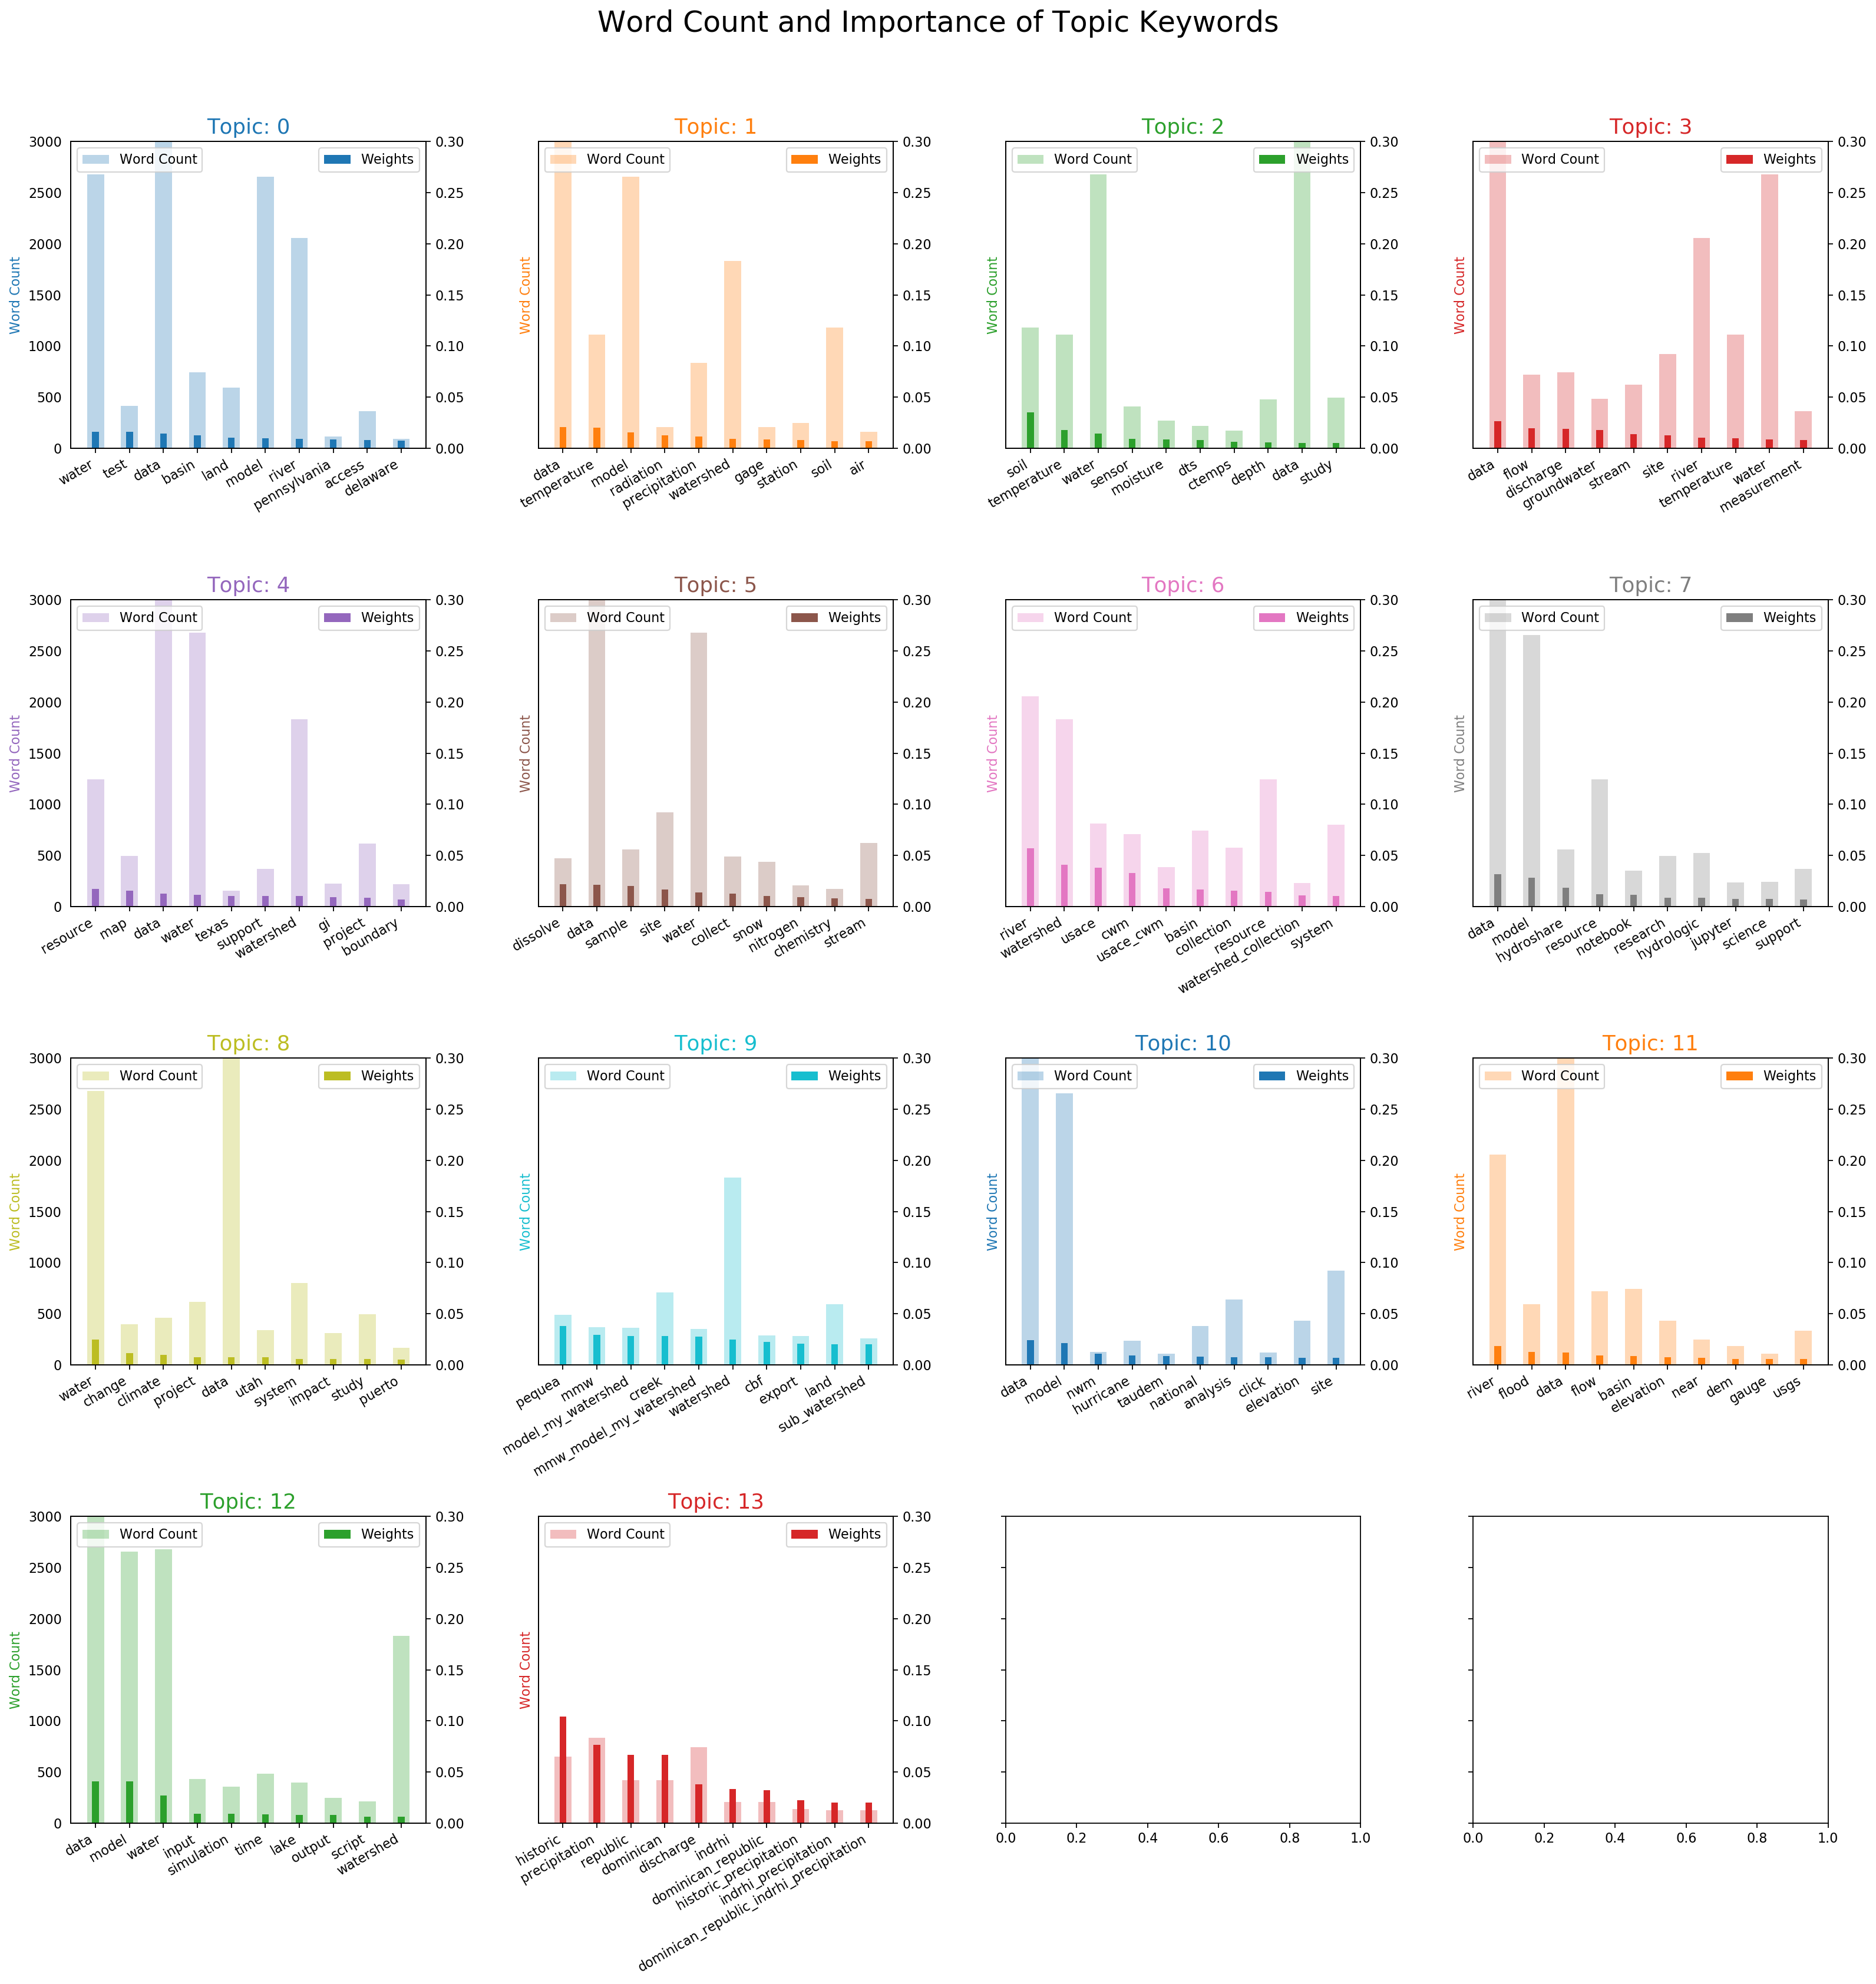

In [13]:
from collections import Counter
topics = model.show_topics(num_topics=num_of_topics, formatted=False)
data_flat = [w for w_list in docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 4, figsize=(20,20), sharey=True, dpi=160)
for i, ax in enumerate(axes.flatten()):
    if i >= len(topics):
        break
    clr = cols[i-len(cols)] if i >= len(cols) else cols[i]
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=clr, width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=clr, width=0.2, label='Weights')    
    ax.set_ylabel('Word Count', color=clr)
    ax_twin.set_ylim(0, 0.3); ax.set_ylim(0, 3000)
    ax.set_title('Topic: ' + str(i), color=clr, fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); 
    ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## **What are the most discussed topics in the training data**

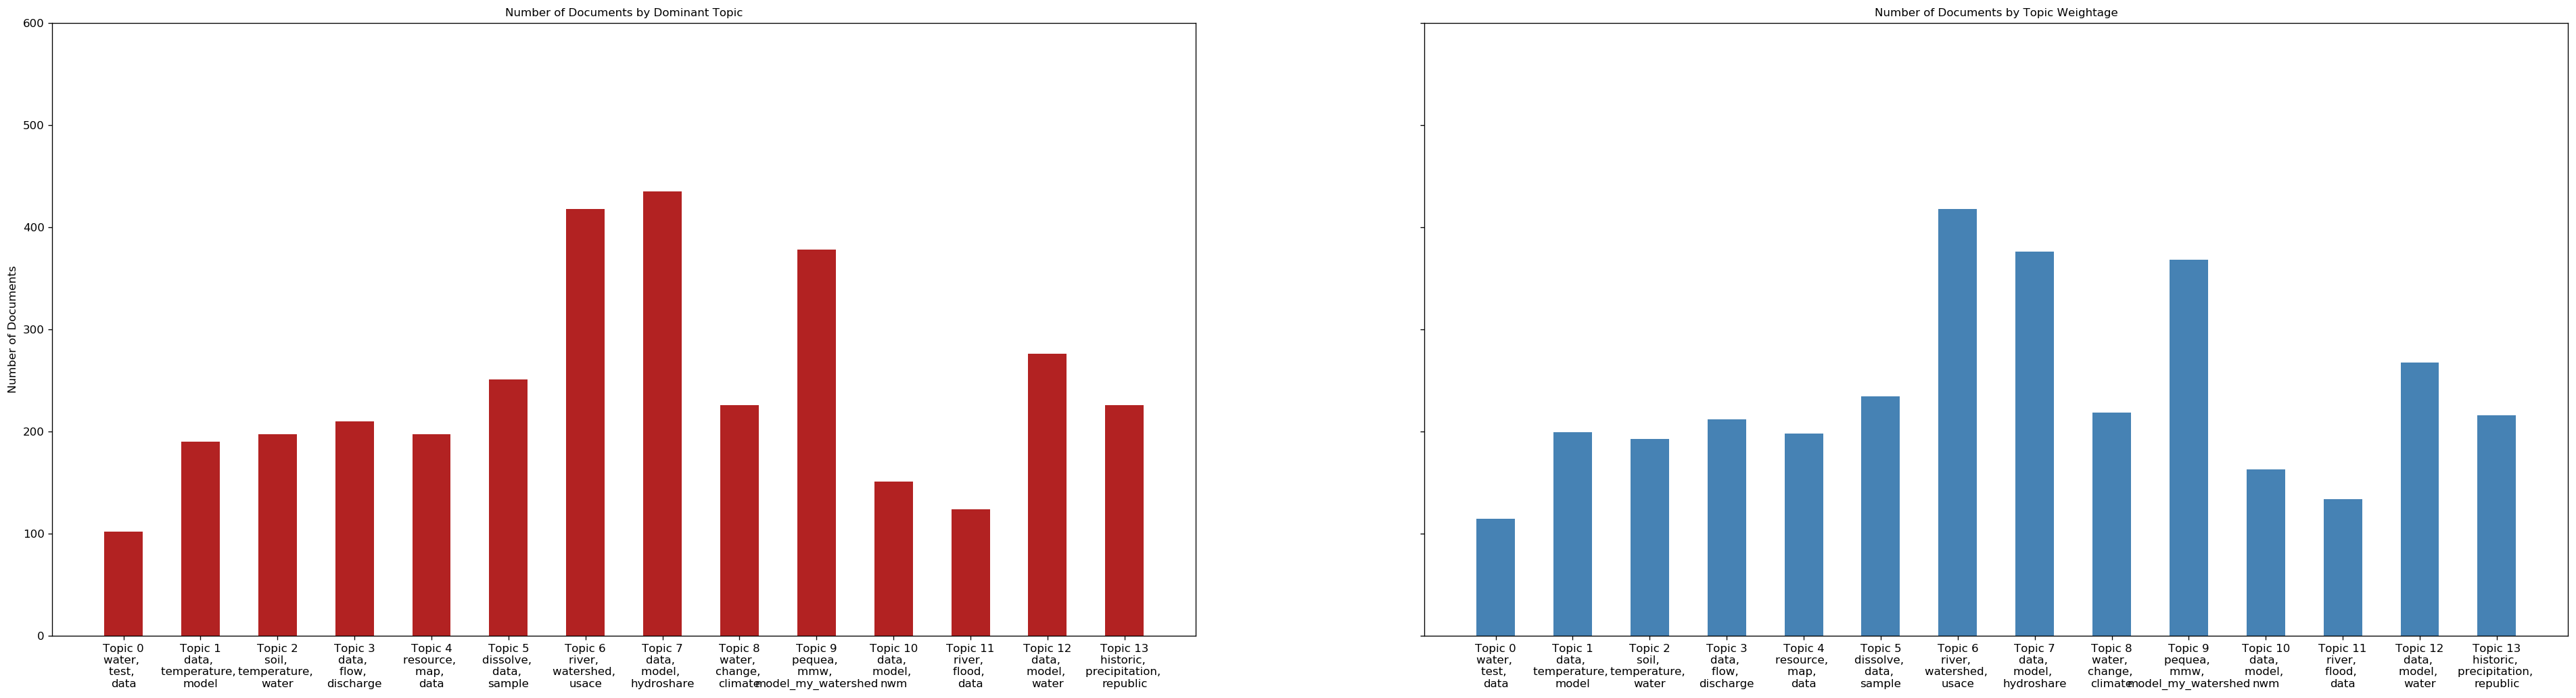

In [14]:
from matplotlib.ticker import FuncFormatter


dominant_topics, topic_percentages = topics_per_document(model=model, corpus=corpus)  

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in model.show_topics(num_topics=num_of_topics, formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 10), dpi=120, sharey=True)
# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 600)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

## **Visualize LDA model using pyLDAVis for training data**

In [15]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary=model.id2word, sort_topics=False)
vis

/opt/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.048176 -0.080112       1        1   3.716778
1      0.005285  0.075173       2        1   6.034769
2      0.133631  0.106378       3        1  10.954464
3      0.091503  0.145215       4        1   8.223259
4      0.004193 -0.141611       5        1   5.539547
5      0.057052  0.248396       6        1   8.679354
6     -0.098450 -0.029171       7        1   9.387824
7      0.117689 -0.171002       8        1  12.100658
8      0.131096 -0.053364       9        1  10.125061
9     -0.214379 -0.097670      10        1   5.213972
10     0.038302 -0.104863      11        1   4.693914
11    -0.048978  0.017129      12        1   3.767107
12     0.126450 -0.028292      13        1   9.244441
13    -0.295218  0.113793      14        1   2.318843, topic_info=     Category         Freq           Term        Total  loglift  logprob
659   Default   555.000000       historic   555.000000  30.0000  30.0000
94    Default  1996.000000          river  1996.000000  29.0000  29.0000
81    Default   750.000000  precipitation   750.000000  28.0000  28.0000
109   Default   816.000000          usace   816.000000  27.0000  27.0000
22    Default   708.000000            cwm   708.000000  26.0000  26.0000
...       ...          ...            ...          ...      ...      ...
1254  Topic14    24.859465           usgs   300.795715   1.2709  -5.3636
3604  Topic14    12.146498        landsat    37.335930   2.6412  -6.0798
3012  Topic14    11.937955          track    55.927067   2.2198  -6.0971
710   Topic14    10.811275          image    79.263893   1.7719  -6.1962
5243  Topic14     9.691607           peru    21.655325   2.9601  -6.3055

[960 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
916       1  0.196244  access
916       4  0.025973  access
916       5  0.037517  access
916       8  0.375172  access
916       9  0.028859  access
...     ...       ...     ...
1587      7  0.012464    zone
1587      9  0.008309    zone
1587     11  0.016619    zone
1587     12  0.112178    zone
1587     13  0.008309    zone

[2345 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

## **Test the model on test data unseen by the model**

In [14]:
#print("total number of test data keywords: ", len(test_keywords), ", keywords: ", test_keywords)
print("total number of test data keywords: ", len(test_keywords))
test_keywords_set = set(flatten(test_keywords))
#print(test_keywords_set)
print("number of test keywords in test_keywords_set", len(test_keywords_set))
print("Number of full test text rows:", len(test_data))

total number of test data keywords:  846
number of test keywords in test_keywords_set 1633
Number of full test text rows: 846


In [15]:
test_docs = [process_text(text) for text in test_data]

#Create Biagram & Trigram Models 
# Add bigrams and trigrams to texts
# higher threshold means few phrases, heavily depends on scoring function, which can be set as 'default' or 'npmi'
test_bigram = Phrases(test_docs, min_count=5, threshold=10, scoring='default') 
test_trigram = Phrases(test_bigram[test_docs])

for idx in range(len(test_docs)):
    for token in test_bigram[test_docs[idx]]:
        if '_' in token and token not in test_docs[idx]:
            # Token is a bigram, add to document.
            test_docs[idx].append(token)
            #print("in bigram processing: ", token)
    for token in test_trigram[test_docs[idx]]:
        if '_' in token and token not in test_docs[idx]:
            # Token is a bigram, add to document.
            test_docs[idx].append(token)
            #print("in trigram processing: ", token)

test_bows = [model.id2word.doc2bow(text) for text in test_docs]

test_sent_topics_df = pd.DataFrame()

for i, row_list in enumerate(model[test_bows]):
    row = row_list[0] if model.per_word_topics else row_list
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:
            wp = model.show_topic(topic_num)
            topic_keywords_list = [word for word, prop in wp]
            topic_keywords = "; ".join(topic_keywords_list)
            # compute cosine similarity between topic keywords and input keywords
            topic_keywords_set = {w for w in topic_keywords_list}
            test_keywords_set = {w for w in test_keywords[i]}
            #rvector = topic_keywords_set.union(input_keywords_set)
            rvector = test_keywords_set
            l1 = []; l2 = []
            for w in rvector:
                if w in topic_keywords_set:
                    l1.append(1)
                else:
                    l1.append(0)
                if w in test_keywords_set:
                    l2.append(1)
                else:
                    l2.append(0)
            dot_product = sum(n1*n2 for n1, n2 in zip(l1, l2))
            mag1 = sum(l1)**0.5
            mag2 = sum(l2)**0.5
            if mag1 == 0 or mag2 == 0:
                cos_sim = 0
            else:    
                cos_sim = dot_product/(mag1*mag2)
            test_sent_topics_df = test_sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords, test_keywords[i], cos_sim]), ignore_index=True)           
        else:
            break
            
contents = pd.Series(test_docs)
test_sent_topics_df = pd.concat([test_sent_topics_df, contents], axis=1)
test_sent_topics_df.reset_index()
test_sent_topics_df.columns = ['Dominant_Topic', 'Percent_Contribution', 'Topic_Keywords', 'Curated', 'Similarity', 'Text']
test_sent_topics_df

#doc_lda = model[bow]
#print('\ndoc_lda:', doc_lda)

#doc_topics, word_topics, phi_values = model.get_document_topics(bow, per_word_topics=True)
#for topic_id, prob in doc_topics:
#    terms = model.show_topic(topic_id)


,Dominant_Topic,Percent_Contribution,Topic_Keywords,Curated,Similarity,Text
0,9.0,0.9704,pequea; mmw; model_my_watershed; creek; mmw_model_my_watershed; watershed; cbf; export; land; su...,"[cbf, mmw, model_my_watershed, pequea]",1.000000,"[land, value, export, sub_watershed, pequea, creek, watershed, cbf, mmw, model_my_watershed, peq..."
1,9.0,0.9704,pequea; mmw; model_my_watershed; creek; mmw_model_my_watershed; watershed; cbf; export; land; su...,"[cbf, mmw, model_my_watershed, pequea]",1.000000,"[land, value, export, sub_watershed, pequea, creek, watershed, cbf, mmw, model_my_watershed, peq..."
2,11.0,0.3532,river; flood; data; flow; basin; elevation; near; dem; gauge; usgs,"[hec_hms, rapidan_river, hms]",0.000000,"[rapidan, river, subbasin, uva, ce_, resource, model, outflow, usgs, station, hec_hms, software,..."
3,4.0,0.4473,resource; map; data; water; texas; support; watershed; gi; project; boundary,"[giswr16, usu, soil, giswr2016, hiroaki_shimada]",0.000000,"[significant, factor, soil, forming, cash, valley, proposal, term, paper, giswr, usu, soil, gisw..."
4,8.0,0.5987,water; change; climate; project; data; utah; system; impact; study; puerto,"[watershed_loading, data_collection, water_quality]",0.000000,"[pre, jordan, lake, report, resource, consist, various, report, document, prepare, army, corp, e..."
...,...,...,...,...,...,...
841,3.0,0.6684,data; flow; discharge; groundwater; stream; site; river; temperature; water; measurement,"[gamut, rb_tm_c, climate_station, knowlton_fork, weo, raw_data, red_butte_canyon, tm_c, universi...",0.000000,"[wasatch, environmental, observatory, red, butte, network, todd, meadow, climate, rb_tm_c, datas..."
842,6.0,0.9718,river; watershed; usace; cwm; usace_cwm; basin; collection; resource; watershed_collection; system,[corps_water_management_system],0.000000,"[usace, cwm, santa, ana, watershed, bank, usace, cwm, santa, ana, watershed, collection, resourc..."
843,6.0,0.9688,river; watershed; usace; cwm; usace_cwm; basin; collection; resource; watershed_collection; system,[corps_management_water_management],0.000000,"[usace, cwm, big, sandy, river, watershed, river, usace, cwm, big, sandy, river, watershed, coll..."
844,2.0,0.6601,soil; temperature; water; sensor; moisture; dts; ctemps; depth; data; study,"[dts, fiber_optic, ctemps]",0.816497,"[autonomous, distribute, temperature, sense, long_term, heat, application, remote, distribute, t..."


In [16]:
test_sent_topics_df.to_csv('testing_topic_info_data_frame_accurate_14.csv')

In [18]:
test_sim_series = test_sent_topics_df['Similarity']
test_zero_cnt = test_sim_series.astype(bool).sum()
print("mean of similarity measures: ", test_sim_series.mean())
print("number of zeros:", test_zero_cnt, "number of non-zeros:", test_sim_series.count()-test_zero_cnt)
print("mean of non-zero similarity measures: ", test_sim_series.replace(0, numpy.NaN).mean())

mean of similarity measures:  0.23215124657711644
number of zeros: 272 number of non-zeros: 574
mean of non-zero similarity measures:  0.7220586566332372


## **Find the most representative text for each topic in test data**

In [18]:
test_sent_topics_sorted_df = pd.DataFrame()
test_sent_topics_grp_df = test_sent_topics_df.groupby('Dominant_Topic')
for i, grp in test_sent_topics_grp_df:
    test_sent_topics_sorted_df = pd.concat([test_sent_topics_sorted_df, grp.sort_values(['Percent_Contribution'], ascending=False).head(1)], axis=0)
print("Mean of dominant_topic_percent_contribution: ", test_sent_topics_sorted_df[['Percent_Contribution']].mean(axis=0))    
# Reset Index    
test_sent_topics_sorted_df.reset_index(drop=True, inplace=True)
test_sent_topics_sorted_df

Mean of dominant_topic_percent_contribution:  Percent_Contribution    0.97655
dtype: float64


,Dominant_Topic,Percent_Contribution,Topic_Keywords,Curated,Text
0,0.0,0.9975,water; test; data; basin; land; model; river; pennsylvania; access; delaware,"[nhd, creek, stream, 305b, surface, rivers, attain, national_hydrography_dataset, category_5, 30...","[integrated, list, attain, layer, show, attain, segment, integrated, list, stream, integrate, li..."
1,1.0,0.9897,data; temperature; model; radiation; precipitation; watershed; gage; station; soil; air,"[wind_direction, wind_speed, relative_humidity, catalina_jemez, jemez_2011_burned_zob, meteorolo...","[cjczo, meteorology, site, jemez, burn, zob, standard, meteorological, data, collect, jemez, bur..."
2,2.0,0.9868,soil; temperature; water; sensor; moisture; dts; ctemps; depth; data; study,"[electrical_conductivity, temperature, gordon_gulch, bulk_electrical_conductivity, soil_temperat...","[bcczo, electrical, conductivity, soil, moisture, soil, temperature, north_facing, middle, pit, ..."
3,3.0,0.9936,data; flow; discharge; groundwater; stream; site; river; temperature; water; measurement,"[cg_ba, qc1, gamut, stage_discharge, rating_curve, aquatic_station, weo, water_quality, flow, re...","[wasatch, environmental, observatory, red, butte, network, rating, curve, cottam, grove, basic, ..."
4,4.0,0.9923,resource; map; data; water; texas; support; watershed; gi; project; boundary,"[provo_river, watershed, delineation, downstream, divergences]","[watershed, provo, river, river, grove, provo, usa, resource, automatically, create, kml, repres..."
5,5.0,0.9812,dissolve; data; sample; site; water; collect; snow; nitrogen; chemistry; stream,"[neodymium,_dissolved, bromide,_dissolved, nitrogen,_dissolved_nitrite, fluorescence_index, abso...","[cjczo, precipitation, chemistry, santa, catalina, mountain, precipitation, sample, collect, loc..."
6,6.0,0.9789,river; watershed; usace; cwm; usace_cwm; basin; collection; resource; watershed_collection; system,[usace_corps_water_management_system],"[usace, cwm, big, sandy, river, watershed, study, usace, cwm, big, sandy, river, watershed, coll..."
7,7.0,0.9844,data; model; hydroshare; resource; notebook; research; hydrologic; jupyter; science; support,"[jupyterhub, landlab]","[infrastructure, lower, barrier, computational, modeling, earth, surface, ability, test, hypothe..."
8,8.0,0.8876,water; change; climate; project; data; utah; system; impact; study; puerto,"[population_health, puerto_rico]","[population, health, report, puerto, rico, virgin, island, collection, health, summary, document..."
9,9.0,0.9958,pequea; mmw; model_my_watershed; creek; mmw_model_my_watershed; watershed; cbf; export; land; su...,"[soils, ssurgo, soil_survey_geographic, soil_survey]","[philadelphia, county, soil, data, set, digital, soil, survey, generally, detailed, level, soil,..."


## **Visualize LDA model using pyLDAVis for test data**

In [19]:
test_vis = pyLDAvis.gensim.prepare(model, test_bows, dictionary=model.id2word, sort_topics=False)
test_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.048176 -0.080112       1        1   3.703476
1      0.005285  0.075173       2        1   4.968487
2      0.133631  0.106378       3        1  11.740093
3      0.091503  0.145215       4        1   7.818192
4      0.004193 -0.141611       5        1   5.040298
5      0.057052  0.248396       6        1   9.181269
6     -0.098450 -0.029171       7        1   8.877167
7      0.117689 -0.171002       8        1  14.203175
8      0.131096 -0.053364       9        1   9.234009
9     -0.214379 -0.097670      10        1   6.880705
10     0.038302 -0.104863      11        1   4.501048
11    -0.048978  0.017129      12        1   2.943260
12     0.126450 -0.028292      13        1   8.492148
13    -0.295218  0.113793      14        1   2.416674, topic_info=     Category        Freq           Term       Total  loglift  logprob
659   Default  129.000000       historic  129.000000  30.0000  30.0000
94    Default  417.000000          river  417.000000  29.0000  29.0000
81    Default  163.000000  precipitation  163.000000  28.0000  28.0000
109   Default  172.000000          usace  172.000000  27.0000  27.0000
75    Default  576.000000          model  576.000000  26.0000  26.0000
...       ...         ...            ...         ...      ...      ...
4361  Topic14    4.610989      landslide   32.924789   1.7570  -5.5894
3604  Topic14    2.823913        landsat    7.976820   2.6844  -6.0798
3012  Topic14    2.775429          track   12.875386   2.1883  -6.0971
710   Topic14    2.513490          image   17.726532   1.7694  -6.1962
5243  Topic14    2.253181           peru    4.379331   3.0582  -6.3055

[951 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
916       1  0.178898  access
916       4  0.023853  access
916       5  0.035780  access
916       8  0.405503  access
916       9  0.023853  access
...     ...       ...     ...
1587      5  0.056382    zone
1587      6  0.281908    zone
1587      7  0.018794    zone
1587     11  0.018794    zone
1587     12  0.093969    zone

[2067 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

## **Save the model which can be loaded directly later**

In [19]:
model_file_name = '/projects/hackathon/ML-Training/hs-ml/data/model/hs_lda_model'

# save model to disk
model.save(model_file_name)

## **Save model results for topic classification to validate the model**

In [25]:
topic_output_data = '/projects/hackathon/ML-Training/hs-ml/data/topic_data/topics_14.csv'

%time all_docs = [process_text(text) for text in all_texts]
all_bigram = Phrases(all_docs, min_count=5, threshold=10, scoring='default') 
all_trigram = Phrases(all_bigram[all_docs])

for idx in range(len(all_docs)):
    for token in all_bigram[all_docs[idx]]:
        if '_' in token and token not in all_docs[idx]:
            # Token is a bigram, add to document.
            all_docs[idx].append(token)
            #print("in bigram processing: ", token)
    for token in all_trigram[all_docs[idx]]:
        if '_' in token and token not in all_docs[idx]:
            # Token is a bigram, add to document.
            all_docs[idx].append(token)
            #print("in trigram processing: ", token)

all_corpus = [model.id2word.doc2bow(text) for text in all_docs]
print('number of documents in all_corpus', len(all_corpus))


CPU times: user 30.3 s, sys: 96.5 ms, total: 30.4 s
Wall time: 30.4 s
number of documents in all_corpus 4228


In [27]:
with open(topic_output_data, 'w', newline='', encoding='utf-8') as f:
    output_writer = csv.writer(f)
    header_list = ['UUID', 'Status', 'Title', 'Keywords', 'Topics']
    output_writer.writerow(header_list)
    cnt = 0
    for i, row_list in enumerate(model[all_corpus]):
        row = row_list[0] if model.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = model.show_topic(topic_num, topn=20)
                topic_keywords = "; ".join([word for word, prop in wp])
                output_writer.writerow([all_data[i][0], all_data[i][1], all_data[i][2], all_data[i][3], topic_keywords])
                cnt += 1
            else:
                break
            
    print('cnt=', cnt)

cnt= 4228
